In [ ]:
!pip install traffic

In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import networkx as nx
from functools import partialmethod
from google.colab import drive
import os
import glob
from traffic.data import airports
import altair as alt
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox


pick which airports to analyse in this runtime

In [ ]:
icaolistE=["LTFM","LFPG","EHAM","EDDF","LEMD","EGLL","LIRF","EDDM","LEBL","EGKK"]
markerE='d-'
colorE='peru'
icaolist = icaolistE
countryname = "zenodo"
markerToUse = markerE
colorToUse = colorE


where to read and save the data (and making sure that the directory exist)

In [ ]:
drive.mount('/content/drive')
folder_path = "/content/drive/My Drive/2024KomplexeNetze/Daten"
if not os.path.exists(folder_path):
    print(f'No such folder: {folder_path}')
csv_files = sorted(glob.glob(os.path.join(folder_path, f"*{countryname}.csv")))
print(csv_files)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['/content/drive/My Drive/2024KomplexeNetze/Daten/20190101_20190131_zenodo.csv']


--------------------------------------------

## Main Part

--------------------------------------------

now loop over the csv files, processing them one by one:
 - create directed graph
 - use networkX to get betweenness centrality


In [ ]:
# Get the current date and time
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

csv_file=csv_files[0]


flightdata = pd.read_csv(csv_file, parse_dates=["firstseen", "lastseen", "day"])
print(csv_file)

#replace origin column name with departure
flightdata.rename(columns={'origin': 'departure'}, inplace=True)
#replace destination column name with arrival
flightdata.rename(columns={'destination': 'arrival'}, inplace=True)

# drop NAN rows if the nan is either in origin or destination
flightdata.dropna(subset=['departure'], inplace=True)
flightdata.dropna(subset=['arrival'], inplace=True)
#flightdata.dropna(inplace=True)
flightdata.describe()

#replace all entries EDDT with EDDB  for account for Berlin-Brandenburg replacing Tegel in 2020
flightdata['departure'] = flightdata['departure'].replace('EDDT', 'EDDB')
flightdata['arrival'] = flightdata['arrival'].replace('EDDT', 'EDDB')

departure_counts = flightdata['departure'].value_counts()
eddm_count = departure_counts.get('EDDH', 0)
eddf_count = departure_counts.get('EDDF', 0)
print(f"at the start: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

#flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="departure", right_on="icao", how="left", )
#flightdata = flightdata.rename(columns={"municipality": "departure_city"})
#flightdata=flightdata.merge(airports.data[["icao", "municipality"]], left_on="arrival", right_on="icao", how="left", )
#flightdata = flightdata.rename(columns={"municipality": "arrival_city"})

# add a column to flightdata dataframe with contains month-and-year
flightdata['month_and_year'] = flightdata['day'].dt.strftime('%Y-%m')

# query dataframe for everything starting/ending at one of the selected airports
#flightdata = flightdata[flightdata['departure'].isin(icaolist) | flightdata['arrival'].isin(icaolist)]
#flightdata = flightdata[flightdata['departure'].isin(icaolist)]


<ipython-input-94-fd9b931de483>:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  flightdata = pd.read_csv(csv_file, parse_dates=["firstseen", "lastseen", "day"])


/content/drive/My Drive/2024KomplexeNetze/Daten/20190101_20190131_zenodo.csv
at the start: The departure value 'EDDF' appears 12444 times, and EDDM 4048 times.


In [ ]:
flightdata.tail()

,callsign,number,icao24,registration,typecode,departure,arrival,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,month_and_year
2145458,CFS7695,NaN,aa30e6,N756FX,C208,6WA5,KBLI,2019-01-31 23:44:05+00:00,2019-01-31 23:58:56+00:00,2019-01-31 00:00:00+00:00,48.582138,-122.985605,304.8,48.810021,-122.543961,281.94,2019-01
2145462,N88HM,NaN,ac1c37,N88HM,BE9L,KHRL,KMFE,2019-01-31 23:44:40+00:00,2019-01-31 23:58:09+00:00,2019-01-31 00:00:00+00:00,26.192780,-97.655450,304.8,26.161972,-98.227257,60.96,2019-01
2145463,N267AM,NaN,a2990a,N267AM,AS50,AZ79,KFFZ,2019-01-31 23:45:24+00:00,2019-01-31 23:57:35+00:00,2019-01-31 00:00:00+00:00,33.531006,-112.104437,304.8,33.590607,-111.605847,853.44,2019-01
2145464,UAE564,NaN,89621b,A6-EGZ,B77W,OMDB,OMDB,2019-01-31 23:45:57+00:00,2019-01-31 23:56:28+00:00,2019-01-31 00:00:00+00:00,25.248379,55.359459,-304.8,25.254961,55.353850,-22.86,2019-01
2145466,N919SF,NaN,acb9b0,N919SF,NaN,OK60,KPWA,2019-01-31 23:46:42+00:00,2019-01-31 23:59:34+00:00,2019-01-31 00:00:00+00:00,34.996995,-97.767506,609.6,35.528000,-97.573414,548.64,2019-01


In [ ]:
month_year = flightdata['month_and_year'].unique()[0]

# Filter the flightdata for the chosen year_month
filtered_flightdata = flightdata[flightdata['month_and_year'] == month_year]

filtered_flightdata.tail()

,callsign,number,icao24,registration,typecode,departure,arrival,firstseen,lastseen,day,latitude_1,longitude_1,altitude_1,latitude_2,longitude_2,altitude_2,month_and_year
2145458,CFS7695,NaN,aa30e6,N756FX,C208,6WA5,KBLI,2019-01-31 23:44:05+00:00,2019-01-31 23:58:56+00:00,2019-01-31 00:00:00+00:00,48.582138,-122.985605,304.8,48.810021,-122.543961,281.94,2019-01
2145462,N88HM,NaN,ac1c37,N88HM,BE9L,KHRL,KMFE,2019-01-31 23:44:40+00:00,2019-01-31 23:58:09+00:00,2019-01-31 00:00:00+00:00,26.192780,-97.655450,304.8,26.161972,-98.227257,60.96,2019-01
2145463,N267AM,NaN,a2990a,N267AM,AS50,AZ79,KFFZ,2019-01-31 23:45:24+00:00,2019-01-31 23:57:35+00:00,2019-01-31 00:00:00+00:00,33.531006,-112.104437,304.8,33.590607,-111.605847,853.44,2019-01
2145464,UAE564,NaN,89621b,A6-EGZ,B77W,OMDB,OMDB,2019-01-31 23:45:57+00:00,2019-01-31 23:56:28+00:00,2019-01-31 00:00:00+00:00,25.248379,55.359459,-304.8,25.254961,55.353850,-22.86,2019-01
2145466,N919SF,NaN,acb9b0,N919SF,NaN,OK60,KPWA,2019-01-31 23:46:42+00:00,2019-01-31 23:59:34+00:00,2019-01-31 00:00:00+00:00,34.996995,-97.767506,609.6,35.528000,-97.573414,548.64,2019-01


In [ ]:
print(filtered_flightdata.shape)

(1114885, 17)


In [ ]:
#departure_counts = filtered_flightdata['departure'].value_counts()
#eddm_count = departure_counts.get('EDDM', 0)
#eddf_count = departure_counts.get('EDDF', 0)
#print(f"after selecting {month_year}: The departure value 'EDDF' appears {eddf_count} times, and EDDM {eddm_count} times.")

# Create a directed graph
weightedgraph = nx.DiGraph()

# Part 1: Add nodes from the flights data
icount=0

filtered_flightdata = filtered_flightdata.reset_index()
for index, row in filtered_flightdata.iterrows():
    origin = row['departure']
    destination = row['arrival']
    icount+=1
    if icount%100000==0:
      print(icount)
    # Add the origin and destination as nodes if they don't exist (and are not identical)
    if origin != destination:
      if origin not in weightedgraph:
          weightedgraph.add_node(origin)
      if destination not in weightedgraph:
          weightedgraph.add_node(destination)
      # add an edge between them if it doesn't exist yet
      if not weightedgraph.has_edge(origin, destination):
          weightedgraph.add_edge(origin, destination)
          #print if this contains eddh and eddf
          if origin== "EDDH" and destination in icaolist:
            print(f'{origin} to {destination}')

print(icount)
nflights= weightedgraph.size(weight="weight")
nroutes=weightedgraph.number_of_edges()
print(f"Number of edges (flight routes): {nroutes}, sum of weights (flights) {nflights}" )
print(list(weightedgraph.degree(['EDDF','EDDM'], weight="weight")))




EDDH to EDDF
EDDH to LFPG
EDDH to EGLL
EDDH to EDDM
EDDH to EGKK
EDDH to LEMD
EDDH to EHAM
EDDH to LIRF
100000
EDDH to LEBL
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1114885
Number of edges (flight routes): 133998, sum of weights (flights) 133998.0
[('EDDF', 593), ('EDDM', 547)]


In [ ]:
trafficgraph = nx.Graph()


In [ ]:
# Load airport data from your Google Drive
airport_data = pd.read_csv('/content/drive/My Drive/2024KomplexeNetze/Daten/airport-coords.csv', sep=',')

# Create a dictionary to store airport coordinates for faster lookup
airport_coords = {}
for _, row in airport_data.iterrows():
    airport_coords[row['icao']] = (row['latitude'], row['longitude'])

# Function to calculate the distance between two airports using their coordinates
from geopy.distance import geodesic

def calculate_distance(airport1, airport2):
    try:
        coords1 = airport_coords[airport1]
        coords2 = airport_coords[airport2]
        return geodesic(coords1, coords2).km
    except KeyError:
        print(f"Warning: Coordinates not found for {airport1} or {airport2}. Using 0 distance.")
        return 0  # or handle the error as appropriate

# Update edge weights in the weightedgraph
for u, v, data in weightedgraph.edges(data=True):
    distance = calculate_distance(u, v)
    data['weight'] = distance  # Replace weight with distance

print("Edge weights updated with distances.")


Streaming output truncated to the last 5000 lines.
Edge weights updated with distances.


In [ ]:
# Remove edges with zero weight (=unknown distance)
for u, v, data in list(weightedgraph.edges(data=True)):
    if data['weight'] == 0:
        weightedgraph.remove_edge(u, v)

print("Edges with zero weight removed.")

# sanity check:  print the edge weights between the node EDDH to all airports in icaolist.
for airport in icaolist:
    try:
        weight = weightedgraph['EDDH'][airport]['weight']
        print(f"Edge weight between EDDH and {airport}: {weight}")
    except KeyError:
        print(f"No edge found between EDDH and {airport}")


Edges with zero weight removed.
No edge found between EDDH and LTFM
Edge weight between EDDH and LFPG: 729.3989953059175
Edge weight between EDDH and EHAM: 381.6128872074943
Edge weight between EDDH and EDDF: 414.5876611058818
Edge weight between EDDH and LEMD: 1781.3570499286782
Edge weight between EDDH and EGLL: 748.1574011279031
Edge weight between EDDH and LIRF: 1324.8677283213644
Edge weight between EDDH and EDDM: 601.0766451347776
Edge weight between EDDH and LEBL: 1493.8504792753176
Edge weight between EDDH and EGKK: 744.9529340641647


[('KTEB', 0.0011842655814713293), ('YSSY', 0.0009643210797046598), ('EHAM', 0.0009277043909224841), ('KLAS', 0.0008752614504765117), ('NZAA', 0.0008554427950564802), ('LSZH', 0.0008276196037685542), ('LFPB', 0.000823353209005133), ('KORD', 0.0008217121336605906), ('KLAX', 0.0008100959374349763), ('KDFW', 0.0007387370486493835), ('CYYZ', 0.0007255823087167618), ('KIAD', 0.0007117248103117018), ('KMIA', 0.0006977005417141785), ('EDDF', 0.0006426825114942424), ('KDAL', 0.0006262327681461685), ('KSFO', 0.0006236839217093914), ('SBGR', 0.0006173318676469641), ('YBBN', 0.0006084837611474639), ('KBFI', 0.0006071039432849122), ('EGGW', 0.0005914915664211834), ('EGSS', 0.0005884360172475197), ('KHPN', 0.0005841267073181403), ('KBOS', 0.0005736681560072055), ('OMDB', 0.0005723066267936405), ('KJFK', 0.0005553988007566062), ('LFPG', 0.0004998144427912778), ('EDDM', 0.00048390669125384874), ('KFLL', 0.0004789368151609724), ('EGLL', 0.0004590116177065674), ('PANC', 0.0004573682409315662), ('KIAH', 

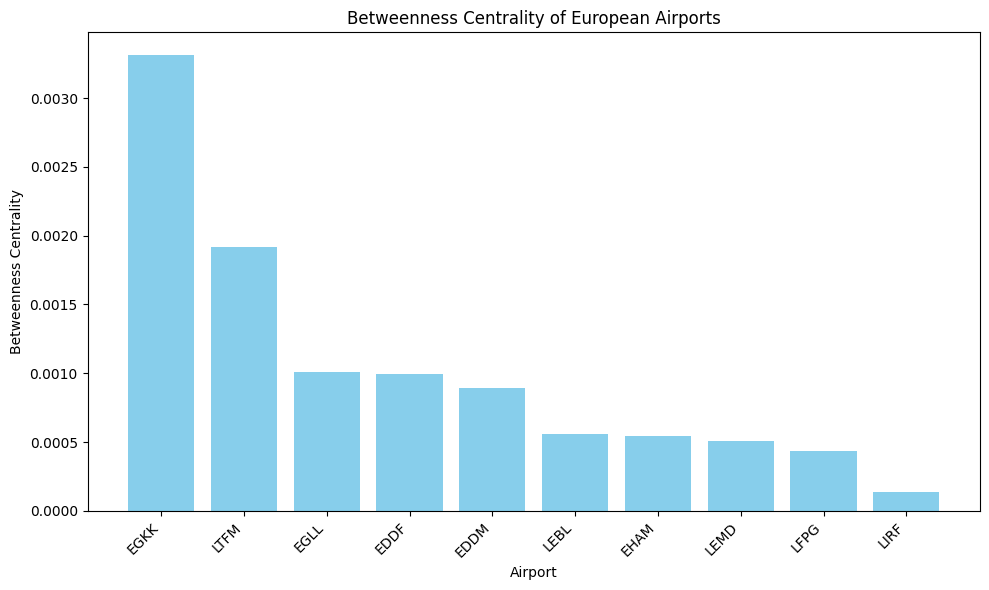

In [ ]:
# Betweenness-Zentralität berechnen
betweenness_centrality = nx.betweenness_centrality(weightedgraph)
#betweenness_centrality = nx.betweenness_centrality(weightedgraph, weight="weight")

# sort the output above
sorted_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
# Extract airport and centrality data
airports = [airport for airport, centrality in sorted_betweenness if airport in icaolist]
centrality_values = [centrality for airport, centrality in sorted_betweenness if airport in icaolist]

print(sorted_betweenness_centrality)
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(airports, centrality_values, color='skyblue')
plt.xlabel("Airport")
plt.ylabel("Betweenness Centrality")
plt.title("Betweenness Centrality of European Airports")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


[('BIKF', 0.0017936324185348108), ('KORD', 0.0010513178210211506), ('EHAM', 0.0010126521509304536), ('YBBN', 0.000991915718006307), ('CYYZ', 0.0009598216471645407), ('NZAA', 0.0009415058453362887), ('KBOS', 0.0008867517221823835), ('KMSP', 0.0007980075205602698), ('EINN', 0.0007953844032130076), ('KBFI', 0.0007307176576626062), ('EIDW', 0.000725876395470817), ('PANC', 0.0006968656380021484), ('YSSY', 0.0006830597572270841), ('KLAS', 0.0006486923180176905), ('LFPB', 0.0006373346801000709), ('CYVR', 0.0006232158660274384), ('KDEN', 0.0006082686991083021), ('KIND', 0.0006077808913209164), ('SBGR', 0.0005597272223031757), ('KIAD', 0.0005305231825036564), ('EFHK', 0.000529234633631317), ('KPTK', 0.000511231765100633), ('KTEB', 0.0005088847653688722), ('KIAH', 0.0004861602856131162), ('KDFW', 0.00047823571004822923), ('RJBB', 0.000477609843453093), ('KJFK', 0.0004739374791669259), ('LPPT', 0.00047288823222802097), ('KMKC', 0.0004603156768021957), ('UUEE', 0.0004490500780897432), ('KOKC', 0.0

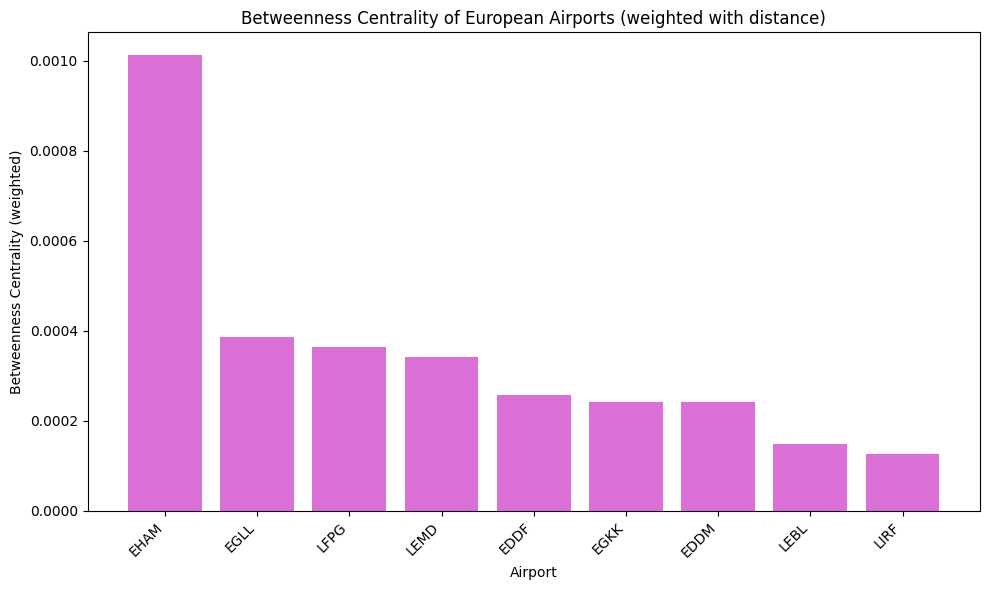

In [ ]:
# Betweenness-Zentralität berechnen - mit Gewichten
betweenness_centrality_w = nx.betweenness_centrality(weightedgraph, weight="weight")

# sort the output above
sorted_betweenness_w = sorted(betweenness_centrality_w.items(), key=lambda x: x[1], reverse=True)
# Extract airport and centrality data
airports_w = [airport for airport, centrality in sorted_betweenness_w if airport in icaolist]
centrality_values_w = [centrality for airport, centrality in sorted_betweenness_w if airport in icaolist]

print(sorted_betweenness_w)
# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(airports_w, centrality_values_w, color='orchid')
plt.xlabel("Airport")
plt.ylabel("Betweenness Centrality (weighted)")
plt.title("Betweenness Centrality of European Airports (weighted with distance)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


EHAM: 0.045376055257099
EDDF: 0.041826554105909436
EDDM: 0.03942824251726784
LFPG: 0.036454336147352266
LEMD: 0.03491941673062164
EGLL: 0.03367229470452801
EGKK: 0.029547198772064465
LEBL: 0.027532617037605525
LIRF: 0.025805832693783576


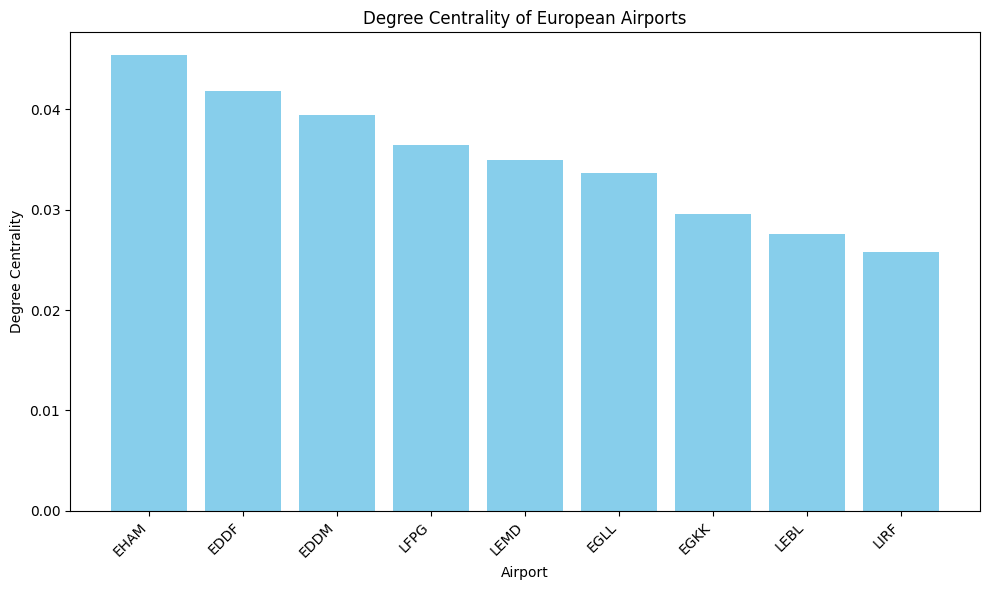

In [ ]:
degree_centrality = nx.degree_centrality(weightedgraph)

# Print degree centrality for airports in icaolist, sorted
sorted_degree = sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)

for airport, centrality in sorted_degree:
  if airport in icaolist:
    print(f"{airport}: {centrality}")

# Extract airport and centrality data
airports = [airport for airport, centrality in sorted_degree if airport in icaolist]
centrality_values = [centrality for airport, centrality in sorted_degree if airport in icaolist]

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.bar(airports, centrality_values, color='skyblue')
plt.xlabel("Airport")
plt.ylabel("Degree Centrality")
plt.title("Degree Centrality of European Airports")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
